# Data Understanding and Feature Engineering

This Notebook ideally follows the `data_exploration` one.

## Autoreload

Autoreload allows the notebook to dynamically load code: if we update some helper functions *outside* of the notebook, we do not need to reload the notebook.

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
# Uncomment the next line and install the package, in case you don't have it in your environment
#%pip install procyclingstats

In [3]:
import ast
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import procyclingstats as pcs
import re
import seaborn as sns
import sys



sys.path.append('../dataset/')
sys.path.append('../utility/')

from utility.data_understanding import *

In the `data_exploration` notebook we've assessed the quality of the data, also adressing some problems that were discovered.

### Dataframes

Motivated by the "imputation by scraping", we decided to retrieve data from (procyclingstats)[https://www.procyclingstats.com/index.php], which is a trusted source of data on cyclism. <br>
The `procyclingstats` notebook details the process of web scraping and data retrieval & augmentation.

In [4]:
cyclist_df = pd.read_csv(os.path.join('dataset','cyclists_new.csv'))
races_df = pd.read_csv(os.path.join('dataset','races_new.csv'))

The dataframes have to be preprocessed in order to be used

In [5]:
cyclist_df = cyclist_df.drop(columns=['Unnamed: 0'], errors='ignore')
cyclist_df['full_history'] = cyclist_df['full_history'].apply(ast.literal_eval)

In [6]:
races_df = races_df.drop(columns=['Unnamed: 0'], errors='ignore')

In [7]:
cyclist_df.head()

,_url,name,birth_year,weight,height,nationality,points_total,tot_seasons_attended,full_history
0,bruno-surra,Bruno Surra,1964.0,NaN,NaN,Italy,15.0,2,"[{'season': 1989, 'points': 14.0, 'rank': 828}..."
1,gerard-rue,Gérard Rué,1965.0,74.0,182.0,France,4717.0,11,"[{'season': 1997, 'points': 164.0, 'rank': 257..."
2,jan-maas,Jan Maas,1996.0,69.0,189.0,Netherlands,315.0,10,"[{'season': 2024, 'points': 30.0, 'rank': 990}..."
3,nathan-van-hooydonck,Nathan Van Hooydonck,1995.0,78.0,192.0,Belgium,953.0,9,"[{'season': 2023, 'points': 298.0, 'rank': 218..."
4,jose-felix-parra,José Félix Parra,1997.0,55.0,171.0,Spain,459.0,5,"[{'season': 2024, 'points': 197.0, 'rank': 317..."


In [8]:
races_df.head()

,_url,name,stage_type,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
0,tour-de-france/1978/stage-6,Tour de France,RR,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,0,sean-kelly,22.0,True,False,False,team/flandria-velda-lano-1978,0.0
1,tour-de-france/1978/stage-6,Tour de France,RR,70.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,1,gerrie-knetemann,27.0,True,False,False,team/ti-raleigh-mc-gregor-1978,0.0
2,tour-de-france/1978/stage-6,Tour de France,RR,50.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,2,rene-bittinger,24.0,True,False,False,team/flandria-velda-lano-1978,0.0
3,tour-de-france/1978/stage-6,Tour de France,RR,40.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,3,joseph-bruyere,30.0,True,False,False,team/c-a-1978,0.0
4,tour-de-france/1978/stage-6,Tour de France,RR,32.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,4,sven-ake-nilsson,27.0,True,False,False,team/miko-mercier-1978,0.0


## Added features

Let's discuss feature augmentation and feature engineering

### Added features (scraping)

We decided to add the following features, obtained by scraping the website:

For the `cyclists` dataset:
- `full_history`: the rider’s points per season history, obtained by reading the *PCS Ranking position per season* table 
- `points_total`: the rider's points accumulated throughout his career, obtained by summing the values in the aforementioned table
- `tot_season_attended`: the number of seasons ran by the cyclist
We decided not to use these features for now, because the data they contain comes from many cyclism disciplines, whereas the data at our disposal only includes road races.

For the `races` dataset:
- `stage_type`: can be RR (Road Race), ITT (Individual Time Trial), TTT (Team Time Trial). Obtained from the stage's webpage

The following changes were made, w.r.t. the original `races` dataset:
- The column `name` now has a unique identifier for each race. Races with identical `_url` prefix are the same race, but in the original dataset they might have been referred with multiple names
- The values in the `points` and `uci_points` column  are now those coming from the website. In the original dataset the (UCI) points were those of the first runner-up 
- The values in the `cyclist_team` column are now those coming from the website. 

In [9]:
cyclist_df = cyclist_df.drop(columns=['points_total', 'tot_seasons_attended','full_history'], errors='ignore')
cyclist_df.head()

,_url,name,birth_year,weight,height,nationality
0,bruno-surra,Bruno Surra,1964.0,NaN,NaN,Italy
1,gerard-rue,Gérard Rué,1965.0,74.0,182.0,France
2,jan-maas,Jan Maas,1996.0,69.0,189.0,Netherlands
3,nathan-van-hooydonck,Nathan Van Hooydonck,1995.0,78.0,192.0,Belgium
4,jose-felix-parra,José Félix Parra,1997.0,55.0,171.0,Spain


### Other added features (races)

By comparing the values with the website, we noticed that the `date` column includes the date of the competition and the time the cyclist took to complete the race. So we disentangle such values.

In [10]:
races_df['time'] = races_df['date'].apply(lambda string: string.split(' ')[1])
races_df['date'] = races_df['date'].apply(lambda string: string.split(' ')[0])

Another feature is the ratio between the vertical meters and the length of the stage, in percentage. This is a "climb density", or steepness.

In [11]:
races_df['steepness'] = 100*races_df['climb_total']/races_df['length']

We also add the season in which a race is ran, by looking at the date.

In [12]:
# 0: winter, 1: spring, 2: summer, 3: fall
races_df['season'] = races_df['date'].apply(lambda data: (int(data.split('-')[1])//3)%4)

**TODO** Le gare hanno un certo ordine! Sarebbe figo trovarlo...

Some competitions are composed of multiple stages, each of which is ran in a different day. One example of this is the Giro d'Italia. Some other are ran in a single stage (that takes a single day), one example being the Ronde van Vlaanedren.

In [13]:
races_df['is_staged'] = races_df['_url'].apply(lambda race_url: bool(re.match(r"[a-z0-9-]+/\d{4}/(prologue|stage-\d)",race_url)))

In [14]:
gare_non_tappe = np.unique([gara.split('/')[0] for gara in races_df.loc[races_df['is_staged'] == False,'_url'].unique()])
gare_tappe = np.unique([gara.split('/')[0] for gara in races_df.loc[races_df['is_staged'],'_url'].unique()])

print(f"Non-staged races: {gare_non_tappe}")
print()
print(f"Staged races: {gare_tappe}")

Non-staged races: ['amstel-gold-race' 'dwars-door-vlaanderen' 'e3-harelbeke' 'gp-montreal'
 'gp-quebec' 'il-lombardia' 'la-fleche-wallone' 'liege-bastogne-liege'
 'milano-sanremo' 'omloop-het-nieuwsblad' 'paris-roubaix'
 'ronde-van-vlaanderen' 'san-sebastian' 'strade-bianche'
 'world-championship']

Staged races: ['dauphine' 'giro-d-italia' 'gran-camino' 'itzulia-basque-country'
 'paris-nice' 'tirreno-adriatico' 'tour-de-france' 'tour-de-romandie'
 'tour-de-suisse' 'uae-tour' 'volta-a-catalunya' 'vuelta-a-espana']


Some competitions take place in the same location each year, while others change location each year.

In [15]:
# Mmm I don't know how to do this... Domain knowledge?

Another trivial yet interesting feature is the country in which the competition is held. It's domain knowledge, summarized in the following dictionary.

**OSS**: This dictionary, and the following cells that create the `race_country` column, use the values of the `name` column in the `races_new.csv` file! 

In [26]:
# For this dictionary I use the names in the races_new.csv format!
country_competition_dict = {
    'France' : ['Tour de France', 
                'Paris - Nice',
                'Criterium du Dauphiné',
                'Paris - Roubaix'],
    'Spain' : ['La Vuelta ciclista a España',
                'Volta Ciclista a Catalunya',
                'Gran Camiño',
                'Itzulia Basque Country',
                'Clasica Ciclista San Sebastian'],
    'Italy' : ['Tirreno-Adriatico', 
               'Milano-Sanremo',
               "Giro d'Italia",
               'Monte Paschi Eroica', 
               'Giro di Lombardia'],
    'Belgium' : ['Ronde van Vlaanderen - Tour des Flandres ME',
                 'La Flèche Wallonne',
                 'E3 BinckBank Classic',
                 'Liège - Bastogne - Liège',
                 'Dwars door België / À travers la Belgique',
                 'Omloop Het Nieuwsblad ME'
                 ],
    'Netherlands' :['Amstel Gold Race'],
    'Switzerland' : ['Tour de Suisse',
                     'Tour de Romandie'],
    'UAE' : ['UAE Tour'],
    'Canada' : ['Grand Prix Cycliste de Quebec', 
                'Grand Prix Cycliste de Montréal']
    # 'World Championships - Road Race' doesn't take place in a fixed country
}

In [21]:
def coutry_returner(race_name:str,
        countries_races_dict:dict[str,list[str]] = country_competition_dict) -> str:
    for country, names_list in countries_races_dict.items():
        if race_name in names_list:
            return country
    return np.nan

races_df['race_country'] = races_df['name'].apply(coutry_returner)

Now, we'll try to infer some value regarding the performance of each individual cyclist at a given age. 
We try to compute an age performance index: it will assign greater values based on the points and the oldness of the cyclist at a given race.

In [ ]:
# First, we normalize the scores
races_df['norm_points'] = races_df.groupby('race_id')['points'].transform(
    lambda x: (x - x.mean()) / x.std()
)
# Then, we multiply by age
races_df['age_performance_index'] = races_df['norm_points'] * races_df['cyclist_age']

Now, we are going to do the same process for the `startlist_quality`. By engineering this feature, we may infer a set of points to assign to each race that is more nuanced towards the expertise of the cyclists that will participate in it.

In [ ]:
races_df['quality_adjusted_points'] = races_df['norm_points'] * races_df['startlist_quality']

Now we'll define a feature to better determine a stamina indicator for each race. We want to take into account any factor that might indicate the need of a better stamina.

In [ ]:
races_df['normalized_length'] = races_df['length'] / races_df['length'].max()
races_df['normalized_quality'] = races_df['startlist_quality'] / races_df['startlist_quality'].max()
races_df['normalized_steepness'] = races_df['steepness'] / races_df['steepness'].max()
races_df['profile_adjustment'] = (races_df['profile'] - 1) / 3
# if we manage to impute temperature would be great to have it normalized and used here. Maybe normalization should be over a bimodal? Higher on the extremes?
# races_df['temperature_impact'] = (races_df['average_temperature'] - 20)**2 / 100 # 20 is the ideal temperature, 100 is 10^2, defines how sensitive the model is to deviations

# Apply weights based on factor importance for stamina
races_df['stamina_index'] = (
    races_df['normalized_length'] * 0.25 +
    races_df['normalized_quality'] * 0.25 +
    races_df['normalized_steepness'] * 0.25 +
    races_df['profile_adjustment'] * 0.25
    # + races_df['temperature_impact'] * 0.25
)


### Other added features (cyclists)

We add the BMI (body Mass Index) of each cyclist: the ratio between the weight (kilograms) and the height in square meters.

In [ ]:
cyclist_df['bmi'] = cyclist_df['weight']/np.square(cyclist_df['height']/100)

Now, let's try to infer an experience level for the cyclists. We should take into account everything, but to have a relaxed yet probably closer-to-the-truth model we'll only take into account the races that the cyclists ran into.

In [ ]:
race_count = races_df.groupby('cyclist')['_url'].count()

race_count_df = pd.DataFrame({'_url': race_count.index, 'race_count': race_count.values})
cyclist_df = cyclist_df.merge(right=race_count_df, how='left', on='_url')
cyclist_df['race_count'] = cyclist_df['race_count'].replace(np.nan, 0)

# now with all of our complete, total, absolute domain knowledge we can define the experience levels
experience_levels = ['beginner', 'developing', 'competitive', 'semi-pro', 'pro']
bins = [0, 15, 50, 100, 200, float('inf')]

cyclist_df['experience_level'] = pd.cut(cyclist_df['race_count'], bins=bins, labels=experience_levels, right=False)

## Studying the (added?) features

Let's do some data understanding with (also) the new features that we discovered!

### `length` vs `stage_type`

Thanks to the domain experts (prof. Setzu) we know that a stage can simply be a road race (RR) or can be a individual time trial (ITT) stage. Furthermore:
- All staged races (e.g. Tour de France) have at least one stage that is ITT
- A ITT differs from a RR for the fact that in the latter all cyclists start at the same time all together, while in a ITT the cyclists start cycling one after the other
- Typically ITTs are shorter

Let's try to see how the `stage_type` compares with the `delta`

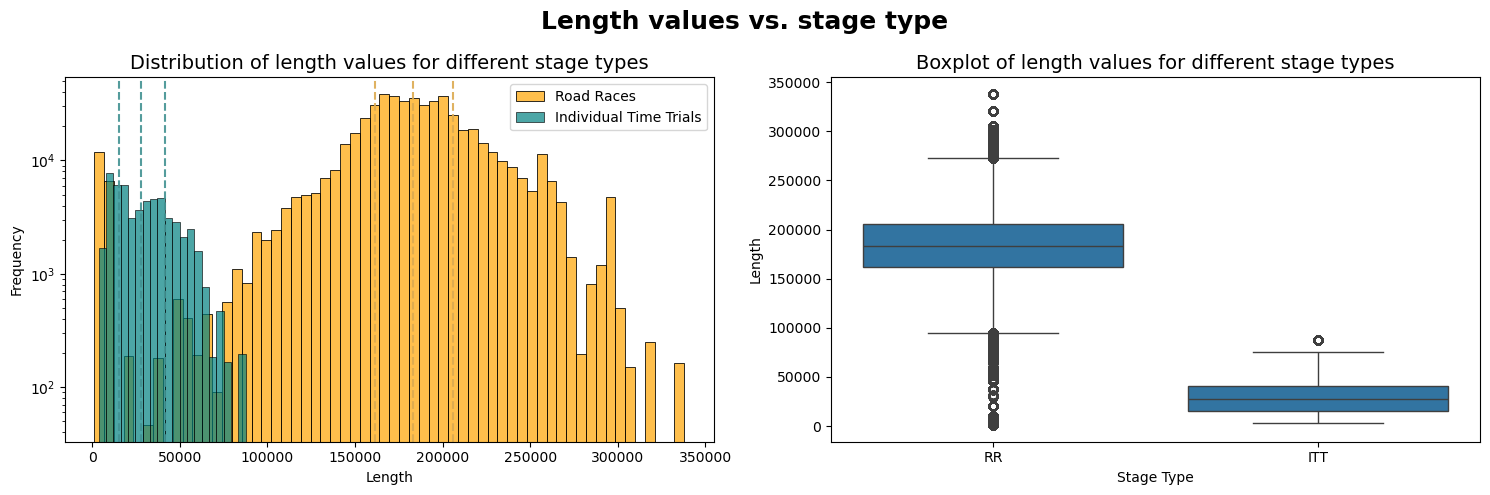

In [41]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Length values vs. stage type', fontsize=18, fontweight='bold')


sns.histplot(races_df.loc[races_df['stage_type'] == 'RR', 'length'], bins=60, kde=False, color='orange', alpha=0.7, label='Road Races', ax=ax[0])
rr_quartiles = races_df.loc[races_df['stage_type'] == 'RR', 'length'].quantile([0.25, 0.5, 0.75])

sns.histplot(races_df.loc[races_df['stage_type'] == 'ITT', 'length'], bins=20, kde=False, color='teal', alpha=0.7, label='Individual Time Trials', ax=ax[0])
itt_quartiles = races_df.loc[races_df['stage_type'] == 'ITT', 'length'].quantile([0.25, 0.5, 0.75])

# Add vertical lines for Road Races quartiles
for q in rr_quartiles:
    ax[0].axvline(q, linestyle='--', color=(220/255,170/255,80/255), alpha=0.9)

# Add vertical lines for Individual Time Trials quartiles
for q in itt_quartiles:
    ax[0].axvline(q, linestyle='--', color=(65/255,145/255,145/255), alpha=0.9)
    
ax[0].set_title('Distribution of length values for different stage types', fontsize=14)
ax[0].set_xlabel('Length')
ax[0].set_ylabel('Frequency')
ax[0].set_yscale('log')
ax[0].legend()

sns.boxplot(data=races_df, x='stage_type', y='length', ax=ax[1])
ax[1].set_title('Boxplot of length values for different stage types', fontsize=14)
ax[1].set_xlabel('Stage Type')
ax[1].set_ylabel('Length')



plt.tight_layout()
plt.show()

As we can see, the two distributions are very well separated visually, but there is some overlap, because there are short road races.

In [ ]:
# Not the best... To review... To do better... Maybe with the name_stage feature?
races_df.loc[(races_df['length'] < 100000) & (races_df['stage_type'] == 'RR'), 'name'].unique()

array(['Volta Ciclista a Catalunya', 'La Vuelta ciclista a España',
       'Tour de Romandie', 'Tour de Suisse', 'Paris - Nice',
       "Giro d'Italia", 'Tour de France', 'Tirreno-Adriatico',
       'Criterium du Dauphiné', 'Itzulia Basque Country'], dtype=object)

In [29]:
races_df.groupby('stage_type')['length'].describe()

,count,mean,std,min,25%,50%,75%,max
stage_type,,,,,,,,
ITT,55804.0,29722.894058,16881.897400,3600.0,15100.0,28000.0,41200.0,87500.0
RR,549036.0,180734.526661,49672.396774,1000.0,161500.0,182900.0,206000.0,338000.0


As we can see, `RR` is the majority class. 

The average length of a `ITT` is 29,7 Km, very close to the median, that is 28 Km. <br>
The average length of a `RR` is 180 Km, very close to the median, that is 183 Km.

We can notice that all the mass of the `ITT`'s length distribution is before the first quartile of the `RR`'s length distribution. 

**TODO**: Correlation? O qualcosa di simile? Dovrei studiarlo...

In [42]:
# Qui ci mettiamo la correlazione o qualcosa del genere.

All in all, `length` is an excellent predictor of `stage_type`, but not a perfect one. It's ok to have the ground truth.